13.41 percent of data is spam: We have an inbalanced data set.


,Category,Message,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


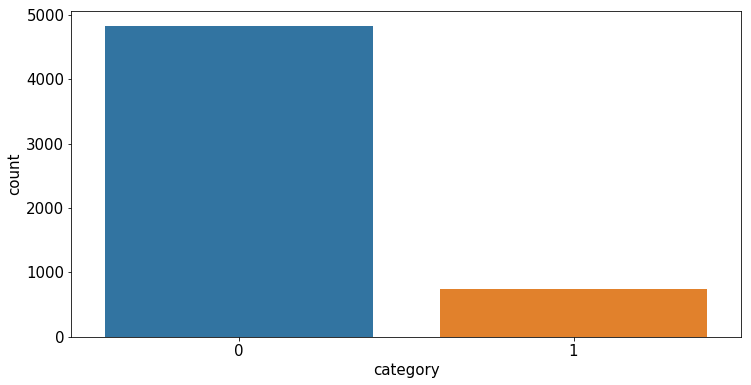

In [3]:
import csv
import pandas as pd
import numpy as np
import nltk
from nltk import word_tokenize, WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from math import log, sqrt



df = pd.read_csv('mails.csv' )
del df['Unnamed: 2']
del df['Unnamed: 3']
del df['Unnamed: 4']


df.rename(columns = {'v1':'Category','v2': 'Message'}, inplace = True)
#Convert from strings to binary:
df['Category'] = df.Category.map({'ham': 0, 'spam': 1})  

df.groupby('Category').describe()

print('%2.2f percent of data is spam: We have an inbalanced data set.'%round(100*sum(df.Category)/len(df),2))
    
category_count = pd.DataFrame()
category_count['count'] = df['Category'].value_counts()


fig, ax = plt.subplots(figsize = (12, 6))
sns.barplot(x = category_count.index, y = category_count['count'], ax = ax)
ax.set_ylabel('count', fontsize = 15)
ax.set_xlabel('category',fontsize = 15)
ax.tick_params(labelsize=15)

df['length'] = df['Message'].apply(len)
df.head()

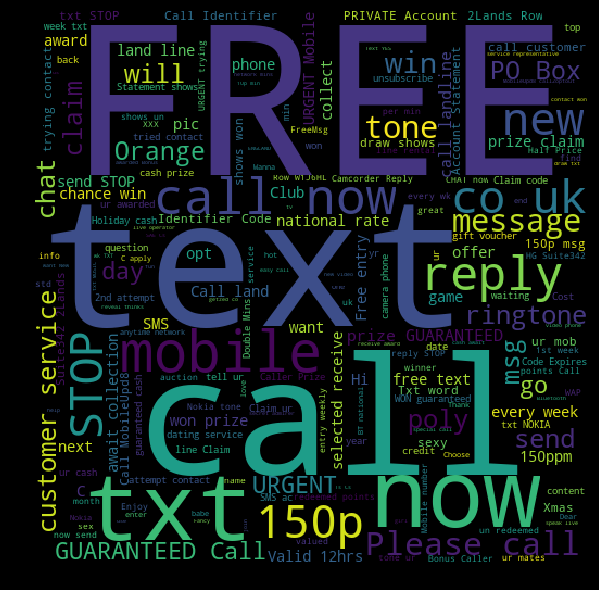

In [4]:
# See all the spam words 
spam_words = ' '.join(list(df[df['Category'] == 1]['Message']))
spam_wc = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()





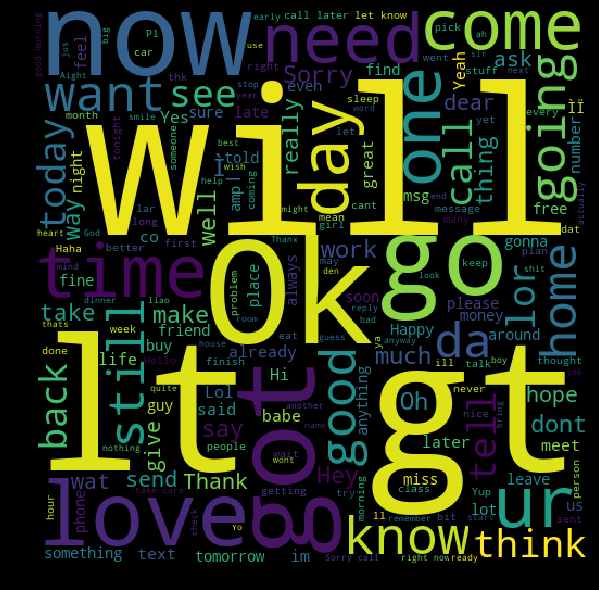

In [5]:
# See all ham words 
ham_words = ' '.join(list(df[df['Category'] == 0]['Message']))
ham_wc = WordCloud(width = 512,height = 512).generate(ham_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(ham_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In [6]:
# In this part we will remove punctiations, stemmed characters, lowercase the words
import string
from nltk.corpus import stopwords
set(stopwords.words('english'))
def text_process(messy_text):
    #Takes in a string of text, then performs the following:
    #1. Remove all punctuation
    #2. Remove all stopwords
    #3. Returns a list of the cleaned text
    
    # Check characters to see if they are in punctuation
    nopunc = [char for char in messy_text if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
      
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]


df['Message'].head(5).apply(text_process)


0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: Message, dtype: object

In [7]:
# Converting our raw messages (sequence of characters) into vectors (sequences of numbers)

In [8]:
# Now we'll convert each message, represented as a list of tokens (lemmas) above, 
# into a vector that machine learning models can understand.

# Doing that requires essentially three steps, in the bag-of-words model:

# 1) counting how many times does a word occur in each message (term frequency)
# 2 ) weighting the counts, so that frequent tokens get lower weight (inverse document frequency)
# 3) normalizing the vectors to unit length, to abstract from the original text length (L2 norm)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

bow_transformer = CountVectorizer(analyzer=text_process)

bow_transformer.fit(df['Message'])




CountVectorizer(analyzer=<function text_process at 0x000001905B3958C8>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,
        stop_words=None, strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None)

In [10]:
#let's see on a specific text

message5 = df['Message'][4]
print (message5)

bow5 = bow_transformer.transform([message5])
print (bow5)



Nah I don't think he goes to usf, he lives around here though
  (0, 2897)	1
  (0, 4698)	1
  (0, 6038)	1
  (0, 6786)	1
  (0, 7740)	1
  (0, 10320)	1
  (0, 10337)	1
  (0, 10681)	1


In [11]:
messages_bow = bow_transformer.transform(df['Message'])


In [12]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)

In [13]:
tfidf5 = tfidf_transformer.transform(bow5) # bow transform for the 5th message

print (tfidf5)

  (0, 10681)	0.40173624834617694
  (0, 10337)	0.3539244191334122
  (0, 10320)	0.27032457509133806
  (0, 7740)	0.4455603976230396
  (0, 6786)	0.3539244191334122
  (0, 6038)	0.2425048093840929
  (0, 4698)	0.31029495356660663
  (0, 2897)	0.40173624834617694


In [14]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print (messages_tfidf.shape)


(5572, 11304)


In [15]:
# Split test and training data

trainIndex, testIndex = list(), list()
for i in range(df.shape[0]):
    if np.random.uniform(0, 1) < 0.80: # Splitting %80 to training and %20 for testing
        trainIndex += [i]
    else:
        testIndex += [i]
trainData = df.loc[trainIndex]
testData = df.loc[testIndex]

In [16]:
trainData.reset_index(inplace = True)
trainData.drop(['index'], axis = 1, inplace = True)
trainData.head()

,Category,Message,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [17]:
testData.reset_index(inplace = True)
testData.drop(['index'], axis = 1, inplace = True)
testData.head()

,Category,Message,length
0,0,I'm gonna be home soon and i don't want to tal...,109
1,0,Aft i finish my lunch then i go str down lor. ...,88
2,0,Just forced myself to eat a slice. I'm really ...,144
3,0,K tell me anything about you.,29
4,1,Thanks for your subscription to Ringtone UK yo...,159


In [18]:
trainData['Category'].value_counts()


0    3867
1     606
Name: Category, dtype: int64

In [19]:
testData['Category'].value_counts()


0    958
1    141
Name: Category, dtype: int64

In [20]:
class SpamClassifier(object):
    def __init__(self, trainData, method = 'tf-idf'):
        self.mails, self.labels = trainData['Message'], trainData['Category']
        self.method = method

    def train(self):
        self.calc_TF_and_IDF()
        if self.method == 'tf-idf':
            self.calc_TF_IDF()
        else:
            self.calc_prob()

    def calc_prob(self):
        self.prob_spam = dict()
        self.prob_ham = dict()
        for word in self.tf_spam:
            self.prob_spam[word] = (self.tf_spam[word] + 1) / (self.spam_words + \
                                                                len(list(self.tf_spam.keys())))
        for word in self.tf_ham:
            self.prob_ham[word] = (self.tf_ham[word] + 1) / (self.ham_words + \
                                                                len(list(self.tf_ham.keys())))
        self.prob_spam_mail, self.prob_ham_mail = self.spam_mails / self.total_mails, self.ham_mails / self.total_mails 
    def calc_TF_and_IDF(self):
        noOfMessages = self.mails.shape[0]
        self.spam_mails, self.ham_mails = self.labels.value_counts()[1], self.labels.value_counts()[0]
        self.total_mails = self.spam_mails + self.ham_mails
        self.spam_words = 0
        self.ham_words = 0
        self.tf_spam = dict()
        self.tf_ham = dict()
        self.idf_spam = dict()
        self.idf_ham = dict()
        for i in range(noOfMessages):
            message_processed = text_process(self.mails[i])
            count = list() #To keep track of whether the word has ocured in the message or not.
                           #For IDF
            for word in message_processed:
                if self.labels[i]:
                    self.tf_spam[word] = self.tf_spam.get(word, 0) + 1
                    self.spam_words += 1
                else:
                    self.tf_ham[word] = self.tf_ham.get(word, 0) + 1
                    self.ham_words += 1
                if word not in count:
                    count += [word]
            for word in count:
                if self.labels[i]:
                    self.idf_spam[word] = self.idf_spam.get(word, 0) + 1
                else:
                    self.idf_ham[word] = self.idf_ham.get(word, 0) + 1
    def calc_TF_IDF(self):
        self.prob_spam = dict()
        self.prob_ham = dict()
        self.sum_tf_idf_spam = 0
        self.sum_tf_idf_ham = 0
        for word in self.tf_spam:
            self.prob_spam[word] = (self.tf_spam[word]) * log((self.spam_mails + self.ham_mails) \
                                                          / (self.idf_spam[word] + self.idf_ham.get(word, 0)))
            self.sum_tf_idf_spam += self.prob_spam[word]
        for word in self.tf_spam:
            self.prob_spam[word] = (self.prob_spam[word] + 1) / (self.sum_tf_idf_spam + len(list(self.prob_spam.keys())))
            
        for word in self.tf_ham:
            self.prob_ham[word] = (self.tf_ham[word]) * log((self.spam_mails + self.ham_mails) \
                                                          / (self.idf_spam.get(word, 0) + self.idf_ham[word]))
            self.sum_tf_idf_ham += self.prob_ham[word]
        for word in self.tf_ham:
            self.prob_ham[word] = (self.prob_ham[word] + 1) / (self.sum_tf_idf_ham + len(list(self.prob_ham.keys())))
            
    
        self.prob_spam_mail, self.prob_ham_mail = self.spam_mails / self.total_mails, self.ham_mails / self.total_mails 
    def classify(self, processed_message):
        pSpam, pHam = 0, 0
        for word in processed_message:                
            if word in self.prob_spam:
                pSpam += log(self.prob_spam[word])
            else:
                if self.method == 'tf-idf':
                    pSpam -= log(self.sum_tf_idf_spam + len(list(self.prob_spam.keys())))
                else:
                    pSpam -= log(self.spam_words + len(list(self.prob_spam.keys())))
            if word in self.prob_ham:
                pHam += log(self.prob_ham[word])
            else:
                if self.method == 'tf-idf':
                    pHam -= log(self.sum_tf_idf_ham + len(list(self.prob_ham.keys()))) 
                else:
                    pHam -= log(self.ham_words + len(list(self.prob_ham.keys())))
            pSpam += log(self.prob_spam_mail)
            pHam += log(self.prob_ham_mail)
        return pSpam >= pHam
    
    def predict(self, testData):
        result = dict()
        for (i, message) in enumerate(testData):
            processed_message = text_process(message)
            result[i] = int(self.classify(processed_message))
        return result
    


In [21]:
def metrics(labels, predictions):
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    for i in range(len(labels)):
        true_pos += int(labels[i] == 1 and predictions[i] == 1)
        true_neg += int(labels[i] == 0 and predictions[i] == 0)
        false_pos += int(labels[i] == 0 and predictions[i] == 1)
        false_neg += int(labels[i] == 1 and predictions[i] == 0)
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    Fscore = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)

    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-score: ", Fscore)
    print("Accuracy: ", accuracy)

In [22]:
sc_tf_idf = SpamClassifier(trainData, 'tf-idf')
sc_tf_idf.train()
preds_tf_idf = sc_tf_idf.predict(testData['Message'])
metrics(testData['Category'], preds_tf_idf)

Precision:  0.9719626168224299
Recall:  0.7375886524822695
F-score:  0.8387096774193549
Accuracy:  0.9636032757051866


In [23]:

sc_bow = SpamClassifier(trainData, 'bow')
sc_bow.train()
preds_bow = sc_bow.predict(testData['Message'])
metrics(testData['Category'], preds_bow)

Precision:  0.9863013698630136
Recall:  0.5106382978723404
F-score:  0.6728971962616823
Accuracy:  0.9363057324840764


In [24]:
sample_message_1 = text_process('Hello! I will call you later!')
sc_tf_idf.classify(sample_message_1)

False

In [27]:
sample_message_2 = text_process("You are awarded $5000!")
sc_tf_idf.classify(sample_message_2)

True